# Alzheimer's Detection Model with ViT Head

## Overview
This TensorFlow/Keras model detects Alzheimer’s disease using MRI images. It uses transfer learning with a pre-trained MobileNetV2 as the base network and augments it with a custom Vision Transformer (ViT) head. Training is performed in two phases: initial training with a frozen base model and a fine-tuning phase where certain layers are unfrozen.

## Data Pipeline
- **Dataset Download:**  
  The dataset is downloaded using `kagglehub` and is expected to contain PNG images sorted into folders by diagnosis.
- **Label Mapping:**  
  Two mappings are defined:
  - Numeric-to-diagnosis (e.g., 0: 'CN', 4: 'AD').
  - Folder name to numeric label.
- **Image Processing:**  
  Images are read from disk, decoded, resized to 160×160, normalized, and their labels are one-hot encoded.
- **Data Pipeline:**  
  Constructed using the `tf.data` API, with operations including shuffling, mapping, caching, batching, and prefetching for efficient training.

## Model Architecture
- **Base Network (MobileNetV2):**  
  - Pre-trained on ImageNet (without the top classifier).
  - Input: 160×160×3 images.
  - **Layer Freezing:** Approximately 90% of the layers are frozen during the initial phase.
  
- **Vision Transformer (ViT) Head:**  
  - **Projection Layer:** Projects patch features into a defined embedding space.
  - **Class Token:** A learnable token is prepended to the patch sequence.
  - **Positional Embeddings:** Learnable positional information is added.
  - **Transformer Blocks:** Multiple blocks consisting of layer normalization, multi-head self-attention, MLP layers (with gelu activation and dropout), and residual connections.
  - **Output:** The final class token is extracted as the representative feature.

- **Classification Head:**
  - A Dropout layer (50%) is applied.
  - A Dense layer with softmax activation outputs class probabilities (for 5 classes).

## Training Strategy
- **Phase 1: Training with Frozen Base**
  - **Objective:** Train only the top layers (ViT head and classifier) while keeping most of the MobileNetV2 weights fixed.
  - **Optimizer:** Adam with a learning rate of 1e-4.
  - **Loss:** Categorical crossentropy.
  - **Epochs:** 5 (initial phase; adjustable).
  
- **Phase 2: Fine-Tuning**
  - **Objective:** Unfreeze the last 10% of the MobileNetV2 layers to fine-tune the model.
  - **Optimizer:** Adam with a reduced learning rate of 1e-5.
  - **Epochs:** Additional 5 epochs (adjustable).

## Evaluation and Visualization
- **Callbacks:**  
  EarlyStopping and ModelCheckpoint are used to prevent overfitting and store the best model based on validation loss.
- **Training Visualization:**  
  A plotting function displays the accuracy and loss curves for both phases.
- **Final Evaluation:**  
  The model is evaluated on the validation set, and the final validation accuracy is reported.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2,ResNet50
from tensorflow.keras.mixed_precision import set_global_policy
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
import kagglehub
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns 
import glob

2025-05-06 19:59:26.255542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746561566.449305      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746561566.505588      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

IMAGE_SIZE = (160, 160)    
BATCH_SIZE = 16           
NUM_CLASSES = 4            
set_global_policy('mixed_float16')
print(f"Mixed precision policy set to: {tf.keras.mixed_precision.global_policy().name}")
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

try:
    data_dir = kagglehub.dataset_download("abdullahtauseef2003/adni-4c-alzheimers-mri-classification-dataset")
    print(f"Dataset downloaded to: {data_dir}")
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Please ensure you are authenticated with Kaggle or specify path manually.")
    if 'data_dir' not in locals() or not os.path.isdir(data_dir):
        print("Exiting: Dataset directory not found.")
        exit()

diagnosis_mapping = { 0: 'CN', 1: 'EMCI', 2: 'LMCI', 3: 'AD' }
dir_to_code = { 'CN': 0, 'EMCI': 1, 'LMCI': 2, 'AD': 3 }

def get_image_paths_and_labels(base_data_dir):
    """Scans potential directories for class subfolders and collects image paths/labels."""
    image_paths = []
    labels = []
    possible_image_dirs = [
        os.path.join(base_data_dir, 'ADNI_4C_MRI_Classification_Dataset', 'AugmentedAlzheimerDataset'),
        os.path.join(base_data_dir, 'AugmentedAlzheimerDataset'),
        os.path.join(base_data_dir, 'ADNI_IMAGES')
    ]
    images_dir = None
    print("--- Searching for Image Directory ---")
    for dir_path in possible_image_dirs:
        print(f"Checking: {dir_path}")
        if os.path.isdir(dir_path):
            has_subdirs = all(os.path.isdir(os.path.join(dir_path, class_name)) for class_name in dir_to_code)
            if has_subdirs:
                 images_dir = dir_path
                 print(f"Found valid image directory: {images_dir}")
                 break
            else:
                 has_any_subdir = any(os.path.isdir(os.path.join(dir_path, class_name)) for class_name in dir_to_code)
                 if has_any_subdir:
                     images_dir = dir_path
                     print(f"Found directory with *some* class subdirs (might be incomplete): {images_dir}")
                     break
                 else:
                     print(f"  > Directory exists but lacks expected class subdirectories.")
        else:
            print(f"  > Directory does not exist.")
    if images_dir is None:
         print(f"\nERROR: Could not find a valid image directory structure within '{base_data_dir}'")
         print("Please check the extracted dataset structure.")
         return np.array(image_paths), np.array(labels)
    print(f"\nUsing image directory: {images_dir}")
    for class_name, class_code in dir_to_code.items():
        class_dir = os.path.join(images_dir, class_name)
        if os.path.isdir(class_dir):
            try:
                files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                for file in files:
                    image_paths.append(os.path.join(class_dir, file))
                    labels.append(class_code)
            except Exception as e: print(f"Error reading directory {class_dir}: {e}")
        else: print(f"Warning: Class directory '{class_dir}' not found.")
    if not image_paths: print("Warning: No image paths were collected.")
    return np.array(image_paths), np.array(labels)

print("\nCollecting image paths and labels...")
image_paths, labels = get_image_paths_and_labels(data_dir)

if len(image_paths) == 0:
    print("\nNo images found. Exiting.")
    exit()

unique, counts = np.unique(labels, return_counts=True)
print("\nClass distribution:")
if len(unique) > 0:
    for label_code, count in zip(unique, counts):
        if label_code in diagnosis_mapping: print(f"Class {diagnosis_mapping[label_code]} (Code: {label_code}): {count} images")
        else: print(f"Class Code {label_code}: {count} images (Warning: Code not in diagnosis_mapping)")
else: print("No labels found.")

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"\nTraining set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
], name="data_augmentation")

def decode_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

def apply_augmentation(image, label):
    image = data_augmentation(image, training=True)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_paths))
train_ds = train_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.batch(BATCH_SIZE)
adni_val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
print(f"\nDataset pipelines created with batch size {BATCH_SIZE}.")

Mixed precision policy set to: mixed_float16
TensorFlow version: 2.18.0
Num GPUs Available:  1
Dataset downloaded to: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset

--- Searching for Image Directory ---
Checking: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset/ADNI_4C_MRI_Classification_Dataset/AugmentedAlzheimerDataset
  > Directory does not exist.
Checking: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset/AugmentedAlzheimerDataset
Found valid image directory: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset/AugmentedAlzheimerDataset
--- Search Complete ---

Using image directory: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset/AugmentedAlzheimerDataset

Class distribution:
Class CN (Code: 0): 6464 images
Class EMCI (Code: 1): 9600 images
Class LMCI (Code: 2): 8960 images
Class AD (Code: 3): 8960 images

Training set: 27187 images
Validation set: 6797 images

Dataset pipelines created with batch size 16.


In [4]:

oasis_root = kagglehub.dataset_download("pulavendranselvaraj/oasis-dataset")
print(f"OASIS root directory: {oasis_root}")

oasis_dir_to_code = {
    'non demented':       0,  # CN
    'very mild dementia': 1,  # EMCI
    'mild dementia':      2,  # LMCI
    'moderate dementia':  3   # AD
}


def get_oasis_paths_and_labels(base_dir):
    image_paths, labels = [], []
    matched = []
    for root, dirs, files in os.walk(base_dir):
        for d in dirs:
            key = d.lower().strip()
            if key in oasis_dir_to_code:
                class_dir = os.path.join(root, d)
                matched.append(class_dir)
                code = oasis_dir_to_code[key]
                for ext in ('*.png', '*.jpg', '*.jpeg'):
                    for fp in glob.glob(os.path.join(class_dir, ext)):
                        image_paths.append(fp)
                        labels.append(code)
    if not matched:
        print("ERROR: No matching OASIS class directories found.\nExpected one of:", list(oasis_dir_to_code.keys()))
    else:
        print("Found OASIS class directories:")
        for md in matched:
            print("  -", md)
    if not image_paths:
        print("ERROR: No OASIS images found. Check directory structure.")
    return np.array(image_paths, dtype=str), np.array(labels, dtype=int)

oasis_paths, oasis_labels = get_oasis_paths_and_labels(oasis_root)
print(f"Total OASIS images: {len(oasis_paths)}")

def decode_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

oasis_ds = tf.data.Dataset.from_tensor_slices((oasis_paths, oasis_labels))
oasis_ds = oasis_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
oasis_ds = oasis_ds.batch(BATCH_SIZE)
oasis_val_ds = oasis_ds.prefetch(tf.data.AUTOTUNE)

OASIS root directory: /kaggle/input/oasis-dataset
Found OASIS class directories:
  - /kaggle/input/oasis-dataset/input/Non Demented
  - /kaggle/input/oasis-dataset/input/Very mild Dementia
  - /kaggle/input/oasis-dataset/input/Moderate Dementia
  - /kaggle/input/oasis-dataset/input/Mild Dementia
Total OASIS images: 9488


In [5]:
all_paths  = np.concatenate([train_paths,  oasis_paths],  axis=0)
all_labels = np.concatenate([train_labels, oasis_labels], axis=0)
#for making a mix dataset os+ad
target_n = 30_000
n_total  = len(all_paths)
if n_total > target_n:
    idx = np.random.permutation(n_total)[:target_n]
    all_paths, all_labels = all_paths[idx], all_labels[idx]
elif n_total < target_n:
    extra_idx = np.random.choice(n_total, size=(target_n - n_total))
    all_paths  = np.concatenate([all_paths,  all_paths[extra_idx]],  axis=0)
    all_labels = np.concatenate([all_labels, all_labels[extra_idx]], axis=0)

all_paths, all_labels = shuffle(all_paths, all_labels, random_state=42)

def decode_and_augment(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = data_augmentation(img, training=True)
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

new_train_ds = (
    tf.data.Dataset
      .from_tensor_slices((all_paths, all_labels))
      .shuffle(buffer_size=len(all_paths))
      .map(decode_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
#ViT Head
class ViTHead(layers.Layer):
    def __init__(self, embed_dim=256, num_heads=4, mlp_dim=512, num_transformer_layers=2, dropout_rate=0.1, **kwargs):
        super(ViTHead, self).__init__(**kwargs)
        self.embed_dim =embed_dim
        self.num_heads= num_heads
        self.mlp_dim =mlp_dim
        self.num_transformer_layers =num_transformer_layers
        self.dropout_rate =dropout_rate

    def build(self, input_shape):
        self.num_patches =input_shape[1] * input_shape[2]  # 5x5 this time 
        self.feature_dim =input_shape[3]
        self.projection =layers.Dense(self.embed_dim)#proj
        self.cls_token =self.add_weight(#cls token gen
            shape=(1, 1, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="cls_token"
        )#pos-embedding
        self.pos_embed = self.add_weight(
            shape=(1, self.num_patches + 1, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="pos_embed"
        )
        self.transformer_blocks = []
        for _ in range(self.num_transformer_layers):
            self.transformer_blocks.append([
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(#mla
                    num_heads=self.num_heads,
                    key_dim=self.embed_dim // self.num_heads,
                    dropout=self.dropout_rate
                ),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(self.mlp_dim, activation="gelu"),
                layers.Dropout(self.dropout_rate),
                layers.Dense(self.embed_dim)
            ])
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        batch_size =tf.shape(inputs)[0]
        x= tf.reshape(inputs, [batch_size, self.num_patches, self.feature_dim])
        x= self.projection(x)
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.embed_dim])
        x= tf.concat([cls_tokens, x], axis=1)
        x= x + self.pos_embed
        
        for norm1, attn, norm2, dense1, drop1, dense2 in self.transformer_blocks:
            x_norm =norm1(x)
            attention_output =attn(x_norm, x_norm, x_norm, training=training)
            x=x+attention_output
            x_norm =norm2(x)
            x_mlp =dense1(x_norm)
            x_mlp =drop1(x_mlp, training=training)
            x_mlp= dense2(x_mlp)
            x = x + x_mlp
        
        x = self.layer_norm(x)
        return x[:, 0]  

# Base-model
base_model=MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMAGE_SIZE, 3)
)

#90%freeze next improvement:~80%
layer_n =len(base_model.layers)
freeze =int(layer_n * 0.9)
for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= freeze)

#complete model
inputs =layers.Input(shape=(*IMAGE_SIZE, 3))
x =base_model(inputs, training=False)
vit_out =ViTHead(embed_dim=256,num_heads=4,mlp_dim=512,num_transformer_layers=2,dropout_rate=0.1)(x)
x =layers.Dropout(0.5)(vit_out)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizers.Adam(1e-4),loss="categorical_crossentropy",metrics=["accuracy"],jit_compile=True)
early_stop = callbacks.EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("alzheimer_mobilenet_phase1.keras",monitor="val_loss",save_best_only=True)

#Phase 1
print("\nPhase 1: Training with frozen base model")#increase epoch next time
history_phase1 = model.fit( new_train_ds,validation_data=val_ds,epochs=7,callbacks=[early_stop, checkpoint])
# Phase 2
for layer in base_model.layers[freeze:]:
    layer.trainable = True
model.compile(optimizer=optimizers.Adam(1e-5),loss="categorical_crossentropy",metrics=["accuracy"],jit_compile=True)


print("\nPhase 2: Fine-tuning")
checkpoint_ft = callbacks.ModelCheckpoint("alzheimer_mobilenet_phase2.keras",monitor="val_loss",save_best_only=True)
history_phase2 = model.fit( new_train_ds, validation_data=val_ds, epochs=8,callbacks=[early_stop, checkpoint_ft])
model.save("final_alzheimer_mobilenet.keras")

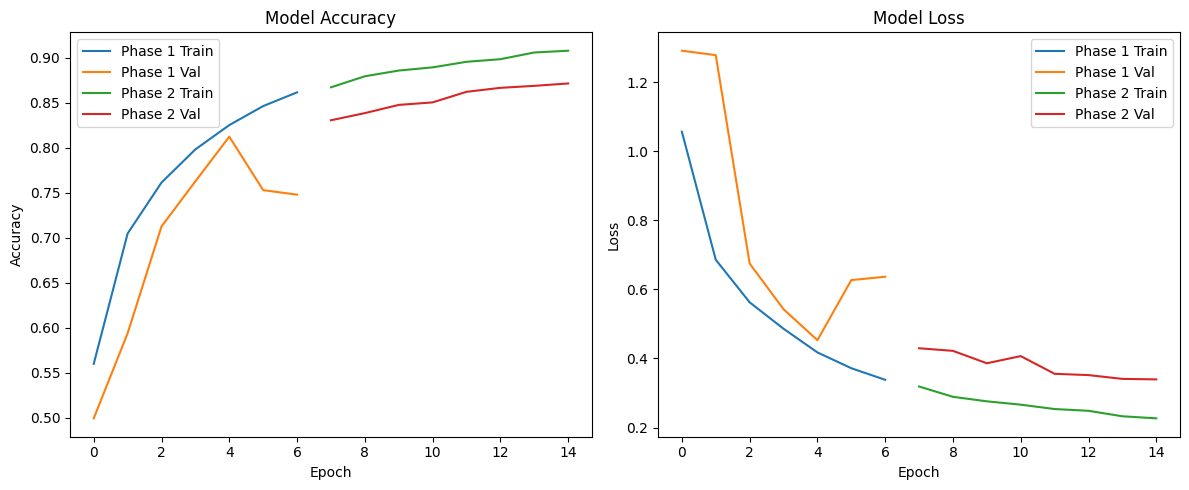

425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8714 - loss: 0.3387

--- Final Evaluation on ADNI Validation Set ---
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8714 - loss: 0.3387
ADNI val_loss: 0.3394, ADNI val_accuracy: 0.8716

--- Final Evaluation on OASIS Dataset ---
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9451 - loss: 0.1732
OASIS loss: 0.1645, OASIS accuracy: 0.9501
425/425 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step
Classification Report:
              precision    recall  f1-score   support

          CN     0.9985    1.0000    0.9992      1293
        EMCI     0.8333    0.8307    0.8320      1920
        LMCI     0.8225    0.7522    0.7858      1792
          AD     0.8661    0.9420    0.9024      1792

    accuracy                         0.8716      6797
   macro avg     0.8801    0.8812    0.8799      6797
weighted avg     0.8705    0.8716    0.8702      6797



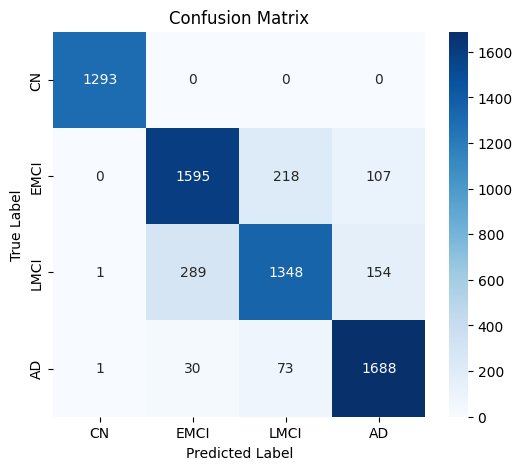

In [13]:
def plot_history(history1, history2):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Phase 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Phase 1 Val')
    offset = len(history1.history['accuracy'])
    x2 = [offset + i for i in range(len(history2.history['accuracy']))]
    plt.plot(x2, history2.history['accuracy'], label='Phase 2 Train')
    plt.plot(x2, history2.history['val_accuracy'], label='Phase 2 Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend() 
    #loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Phase 1 Train')
    plt.plot(history1.history['val_loss'], label='Phase 1 Val')
    plt.plot(x2, history2.history['loss'], label='Phase 2 Train')
    plt.plot(x2, history2.history['val_loss'], label='Phase 2 Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_history(history_phase1, history_phase2)
#Eval
test_loss, test_acc = model.evaluate(val_ds)
# print(f"\nFinal Validation Accuracy: {test_acc}")
# Final evaluation on ADNI val_ds
print("\n--- Final Evaluation on ADNI Validation Set ---")
adni_loss, adni_acc = model.evaluate(val_ds, verbose=1)
print(f"ADNI val_loss: {adni_loss:.4f}, ADNI val_accuracy: {adni_acc:.4f}")

# Final evaluation on OASIS val
print("\n--- Final Evaluation on OASIS Dataset ---")
oasis_loss, oasis_acc = model.evaluate(oasis_ds, verbose=1)
print(f"OASIS loss: {oasis_loss:.4f}, OASIS accuracy: {oasis_acc:.4f}")


y_probs = model.predict(val_ds, verbose=1)           
y_pred = np.argmax(y_probs, axis=-1)           
y_true = np.concatenate([np.argmax(lbl.numpy(), axis=-1) 
                         for _, lbl in val_ds], axis=0)

#C-report:
print("Classification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=[diagnosis_mapping[i] for i in range(NUM_CLASSES)],
    digits=4
))

#Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[diagnosis_mapping[i] for i in range(NUM_CLASSES)],
            yticklabels=[diagnosis_mapping[i] for i in range(NUM_CLASSES)],
            cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

Mobile NeT based ViT architecture ends here

Same architecture but with resnet backbone

In [6]:

#ViT Head
class ViTHead(layers.Layer):
    def __init__(self, embed_dim=256, num_heads=4, mlp_dim=512, num_transformer_layers=2, dropout_rate=0.1, **kwargs):
        super(ViTHead, self).__init__(**kwargs)
        self.embed_dim =embed_dim
        self.num_heads= num_heads
        self.mlp_dim =mlp_dim
        self.num_transformer_layers =num_transformer_layers
        self.dropout_rate =dropout_rate

    def build(self, input_shape):
        self.num_patches =input_shape[1] * input_shape[2]  
        self.feature_dim =input_shape[3]
        self.projection =layers.Dense(self.embed_dim)#proj
        self.cls_token =self.add_weight(#cls token gen
            shape=(1, 1, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="cls_token"
        )#pos-embedding
        self.pos_embed = self.add_weight(
            shape=(1, self.num_patches + 1, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="pos_embed"
        )
        self.transformer_blocks = []
        for _ in range(self.num_transformer_layers):
            self.transformer_blocks.append([
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(#mla
                    num_heads=self.num_heads,
                    key_dim=self.embed_dim // self.num_heads,
                    dropout=self.dropout_rate
                ),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(self.mlp_dim, activation="gelu"),
                layers.Dropout(self.dropout_rate),
                layers.Dense(self.embed_dim)
            ])
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        batch_size =tf.shape(inputs)[0]
        x= tf.reshape(inputs, [batch_size, self.num_patches, self.feature_dim])
        x= self.projection(x)
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.embed_dim])
        x= tf.concat([cls_tokens, x], axis=1)
        x= x + self.pos_embed
        
        for norm1, attn, norm2, dense1, drop1, dense2 in self.transformer_blocks:
            x_norm =norm1(x)
            attention_output =attn(x_norm, x_norm, x_norm, training=training)
            x=x+attention_output
            x_norm =norm2(x)
            x_mlp =dense1(x_norm)
            x_mlp =drop1(x_mlp, training=training)
            x_mlp= dense2(x_mlp)
            x = x + x_mlp
        
        x = self.layer_norm(x)
        return x[:, 0]  

# Base-model
base_model=ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMAGE_SIZE, 3)
)

#90%freeze next improvement:~80%
layer_n =len(base_model.layers)
freeze =int(layer_n * 0.8)
for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= freeze)

#complete model
inputs =layers.Input(shape=(*IMAGE_SIZE, 3))
x =base_model(inputs, training=False)
vit_out =ViTHead(embed_dim=256,num_heads=4,mlp_dim=512,num_transformer_layers=2,dropout_rate=0.1)(x)
x =layers.Dropout(0.5)(vit_out)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizers.Adam(1e-5),loss="categorical_crossentropy",metrics=["accuracy"],jit_compile=True)
early_stop = callbacks.EarlyStopping(monitor="val_loss",patience=4,restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("alzheimer_resnet_phase1.keras",monitor="val_loss",save_best_only=True)

#Phase 1
print("\nPhase 1: Training with frozen base model")#increase epoch next time
history_phase1 = model.fit( new_train_ds,validation_data=val_ds,epochs=10,callbacks=[early_stop, checkpoint])
# Phase 2
for layer in base_model.layers[freeze:]:
    layer.trainable = True
model.compile(optimizer=optimizers.Adam(1e-5),loss="categorical_crossentropy",metrics=["accuracy"],jit_compile=True)


print("\nPhase 2: Fine-tuning")
checkpoint_ft = callbacks.ModelCheckpoint("alzheimer_resnet_phase2.keras",monitor="val_loss",save_best_only=True)
history_phase2 = model.fit( new_train_ds, validation_data=val_ds, epochs=10,callbacks=[early_stop, checkpoint_ft])
model.save("final_alzheimer_resnet.keras")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Phase 1: Training with frozen base model
Epoch 1/10


I0000 00:00:1746520446.181374      92 service.cc:148] XLA service 0x7d4de40021d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746520446.182055      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746520449.467498      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1875 ━━━━━━━━━━━━━━━━━━━━ 1:13 39ms/step - accuracy: 0.3264 - loss: 2.3625   

I0000 00:00:1746520465.814235      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 256s 111ms/step - accuracy: 0.3535 - loss: 1.6528 - val_accuracy: 0.5667 - val_loss: 0.9231
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 153s 82ms/step - accuracy: 0.4920 - loss: 1.1607 - val_accuracy: 0.5330 - val_loss: 1.0802
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 156s 83ms/step - accuracy: 0.5382 - loss: 1.0374 - val_accuracy: 0.6101 - val_loss: 0.8446
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 156s 83ms/step - accuracy: 0.5801 - loss: 0.9440 - val_accuracy: 0.6390 - val_loss: 0.7845
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 155s 83ms/step - accuracy: 0.6051 - loss: 0.8746 - val_accuracy: 0.6434 - val_loss: 0.7440
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 152s 81ms/step - accuracy: 0.6301 - loss: 0.8354 - val_accuracy: 0.6497 - val_loss: 0.7481
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 154s 82ms/step - accuracy: 0.6498 - loss: 0.7937 - val_accuracy: 0.6516 - val_loss: 0.7429
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 154s 82ms/step - accuracy: 0.6655 - l

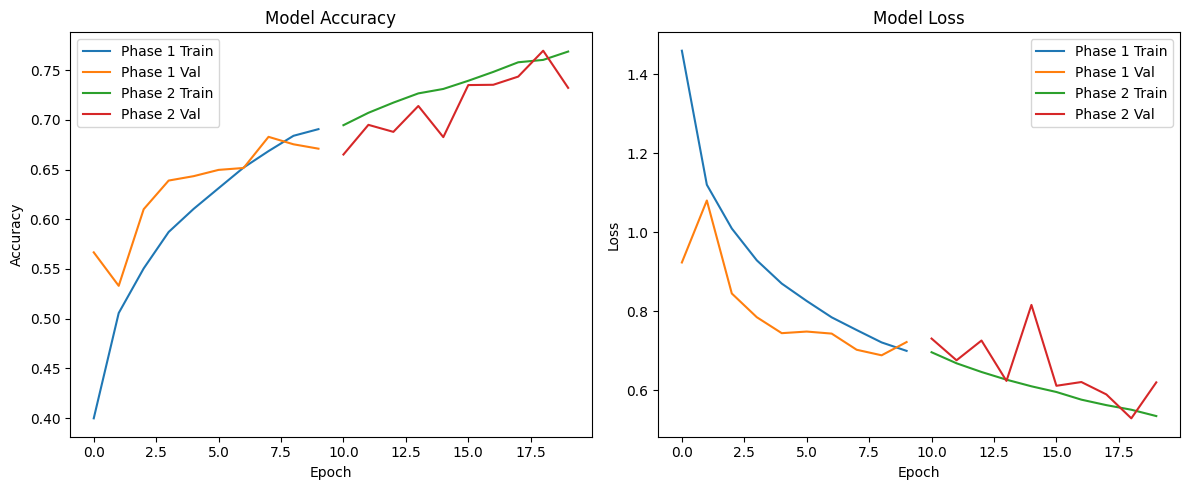

425/425 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7745 - loss: 0.5212

--- Final Evaluation on ADNI Validation Set ---
425/425 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7745 - loss: 0.5212
ADNI val_loss: 0.5282, ADNI val_accuracy: 0.7696

--- Final Evaluation on OASIS Dataset ---
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8779 - loss: 0.3164
OASIS loss: 0.3287, OASIS accuracy: 0.8831
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Classification Report:
              precision    recall  f1-score   support

          CN     0.9749    0.9923    0.9835      1293
        EMCI     0.7463    0.7172    0.7315      1920
        LMCI     0.6579    0.5720    0.6119      1792
          AD     0.7440    0.8627    0.7990      1792

    accuracy                         0.7696      6797
   macro avg     0.7808    0.7860    0.7815      6797
weighted avg     0.7659    0.7696    0.7657      6797



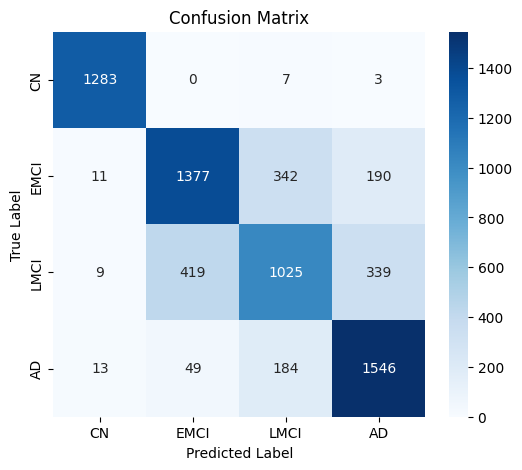

In [8]:
def plot_history(history1, history2):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Phase 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Phase 1 Val')
    offset = len(history1.history['accuracy'])
    x2 = [offset + i for i in range(len(history2.history['accuracy']))]
    plt.plot(x2, history2.history['accuracy'], label='Phase 2 Train')
    plt.plot(x2, history2.history['val_accuracy'], label='Phase 2 Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend() 
    #loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Phase 1 Train')
    plt.plot(history1.history['val_loss'], label='Phase 1 Val')
    plt.plot(x2, history2.history['loss'], label='Phase 2 Train')
    plt.plot(x2, history2.history['val_loss'], label='Phase 2 Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_history(history_phase1, history_phase2)
#Eval
test_loss, test_acc = model.evaluate(val_ds)
# print(f"\nFinal Validation Accuracy: {test_acc}")
# Final evaluation on ADNI val_ds
print("\n--- Final Evaluation on ADNI Validation Set ---")
adni_loss, adni_acc = model.evaluate(val_ds, verbose=1)
print(f"ADNI val_loss: {adni_loss:.4f}, ADNI val_accuracy: {adni_acc:.4f}")

# Final evaluation on OASIS val
print("\n--- Final Evaluation on OASIS Dataset ---")
oasis_loss, oasis_acc = model.evaluate(oasis_ds, verbose=1)
print(f"OASIS loss: {oasis_loss:.4f}, OASIS accuracy: {oasis_acc:.4f}")


y_probs = model.predict(val_ds, verbose=1)           
y_pred = np.argmax(y_probs, axis=-1)           
y_true = np.concatenate([np.argmax(lbl.numpy(), axis=-1) 
                         for _, lbl in val_ds], axis=0)

#C-report:
print("Classification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=[diagnosis_mapping[i] for i in range(NUM_CLASSES)],
    digits=4
))

#Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[diagnosis_mapping[i] for i in range(NUM_CLASSES)],
            yticklabels=[diagnosis_mapping[i] for i in range(NUM_CLASSES)],
            cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

ResNet based ViT ends here

Deit

Mixed precision policy set to: mixed_float16
TensorFlow version: 2.18.0
Num GPUs Available:  1
Dataset downloaded to: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset

--- Searching for Image Directory ---
Checking: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset/ADNI_4C_MRI_Classification_Dataset/AugmentedAlzheimerDataset
  > Directory does not exist.
Checking: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset/AugmentedAlzheimerDataset
Found valid image directory: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset/AugmentedAlzheimerDataset
--- Search Complete ---

Using image directory: /kaggle/input/adni-4c-alzheimers-mri-classification-dataset/AugmentedAlzheimerDataset

Class distribution:
Class CN (Code: 0): 6464 images
Class EMCI (Code: 1): 9600 images
Class LMCI (Code: 2): 8960 images
Class AD (Code: 3): 8960 images

Training set: 27187 images
Validation set: 6797 images


I0000 00:00:1746561611.735376      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Dataset pipelines created with batch size 32.
OASIS root directory: /kaggle/input/oasis-dataset
Found OASIS class directories:
  - /kaggle/input/oasis-dataset/input/Non Demented
  - /kaggle/input/oasis-dataset/input/Very mild Dementia
  - /kaggle/input/oasis-dataset/input/Moderate Dementia
  - /kaggle/input/oasis-dataset/input/Mild Dementia
Total OASIS images: 9488
OASIS root directory: /kaggle/input/oasis-dataset
Found OASIS class directories:
  - /kaggle/input/oasis-dataset/input/Non Demented
  - /kaggle/input/oasis-dataset/input/Very mild Dementia
  - /kaggle/input/oasis-dataset/input/Moderate Dementia
  - /kaggle/input/oasis-dataset/input/Mild Dementia
Total OASIS images: 9488


In [ ]:
DeiT implementation

In [1]:
IMAGE_SIZE = (224, 224)  
NUM_CLASSES = 4  

class DeiTHead(layers.Layer):
    def __init__(self, embed_dim=256, num_heads=4, mlp_dim=512, 
                 num_transformer_layers=2, dropout_rate=0.1, distillation=True, **kwargs):
        super(DeiTHead, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.num_transformer_layers = num_transformer_layers
        self.dropout_rate = dropout_rate
        self.distillation = distillation
        
    def build(self, input_shape):
        self.num_patches = input_shape[1] * input_shape[2] 
        self.feature_dim = input_shape[3]
        self.projection = layers.Dense(self.embed_dim)
        
        # CLS
        self.cls_token = self.add_weight(
            shape=(1, 1, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="cls_token"
        )
        
        # DIST
        if self.distillation:
            self.dist_token = self.add_weight(
                shape=(1, 1, self.embed_dim),
                initializer="random_normal",
                trainable=True,
                name="dist_token"
            )
        self.pos_embed = self.add_weight(
            shape=(1, self.num_patches + (2 if self.distillation else 1), self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="pos_embed"
        )
        
        self.transformer_blocks = []
        for _ in range(self.num_transformer_layers):
            self.transformer_blocks.append([
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(
                    num_heads=self.num_heads,
                    key_dim=self.embed_dim // self.num_heads,
                    dropout=self.dropout_rate
                ),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(self.mlp_dim, activation="gelu"),
                layers.Dropout(self.dropout_rate),
                layers.Dense(self.embed_dim)
            ])
        
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)
        
        if self.distillation:
            self.cls_head = layers.Dense(NUM_CLASSES)
            self.dist_head = layers.Dense(NUM_CLASSES)
        
    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        
        x = tf.reshape(inputs, [batch_size, self.num_patches, self.feature_dim])
        x = self.projection(x)
        
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.embed_dim])
        
        if self.distillation:
            dist_tokens = tf.broadcast_to(self.dist_token, [batch_size, 1, self.embed_dim])
            x = tf.concat([cls_tokens, dist_tokens, x], axis=1)
        else:
            x = tf.concat([cls_tokens, x], axis=1)
        
        x = x + self.pos_embed
        for norm1, attn, norm2, dense1, drop1, dense2 in self.transformer_blocks:
            x_norm = norm1(x)
            attention_output = attn(x_norm, x_norm, x_norm, training=training)
            x = x + attention_output
            x_norm = norm2(x)
            x_mlp = dense1(x_norm)
            x_mlp = drop1(x_mlp, training=training)
            x_mlp = dense2(x_mlp)
            x = x + x_mlp
        
        x = self.layer_norm(x)
        
        if self.distillation:
            cls_token_final = x[:, 0]
            dist_token_final = x[:, 1]
            cls_output = self.cls_head(cls_token_final)
            dist_output = self.dist_head(dist_token_final)
            
            if not training:
                return (cls_output + dist_output) / 2.0
            
            return cls_output, dist_output
        else:
            return x[:, 0]


def create_mobilenet_deit_hybrid(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    
    layer_n = len(base_model.layers)
    freeze = int(layer_n * 0.9)
    for i, layer in enumerate(base_model.layers):
        layer.trainable = (i >= freeze)
    
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    
    deit_outputs = DeiTHead(
        embed_dim=256,
        num_heads=4,
        mlp_dim=512,
        num_transformer_layers=2,
        dropout_rate=0.1,
        distillation=True  
    )(x)
    
    if isinstance(deit_outputs, tuple):
        cls_output, dist_output = deit_outputs
        cls_output = layers.Dropout(0.5)(cls_output)
        dist_output = layers.Dropout(0.5)(dist_output)
        cls_logits = layers.Dense(num_classes, name="cls_head")(cls_output)
        dist_logits = layers.Dense(num_classes, name="dist_head")(dist_output)
        cls_probs = layers.Activation("softmax", name="cls_probs")(cls_logits)
        dist_probs = layers.Activation("softmax", name="dist_probs")(dist_logits)
        
        outputs = layers.Average(name="final_output")([cls_probs, dist_probs])
        model = models.Model(inputs=inputs, outputs=[cls_probs, dist_probs, outputs])
    else:
        x = layers.Dropout(0.5)(deit_outputs)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        model = models.Model(inputs=inputs, outputs=outputs)
    
    return model


def distillation_loss(y_true, cls_pred, dist_pred, temperature=1.0, alpha=0.5):
    ce_loss_cls = tf.keras.losses.categorical_crossentropy(y_true, cls_pred)
    ce_loss_dist = tf.keras.losses.categorical_crossentropy(y_true, dist_pred)
    
    total_loss = alpha * ce_loss_cls + (1 - alpha) * ce_loss_dist
    return total_loss


model = create_mobilenet_deit_hybrid(input_shape=(*IMAGE_SIZE, 3), num_classes=NUM_CLASSES)

class DistillationModel(models.Model):
    def __init__(self, student_model, temperature=1.0, alpha=0.5):
        super(DistillationModel, self).__init__()
        self.student_model = student_model
        self.temperature = temperature
        self.alpha = alpha
        
    def compile(self, optimizer, metrics=None):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:

            outputs = self.student_model(x, training=True)
            cls_pred = outputs[0]  
            dist_pred = outputs[1]  
            cls_pred = tf.reshape(cls_pred, [-1, NUM_CLASSES])  
            dist_pred = tf.reshape(dist_pred, [-1, NUM_CLASSES]) 
            ce_loss_cls = self.loss_fn(y, cls_pred)
            ce_loss_dist = self.loss_fn(y, dist_pred)
            loss = self.alpha * ce_loss_cls + (1 - self.alpha) * ce_loss_dist  

        trainable_vars = self.student_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, cls_pred)  

        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": loss, "cls_loss": ce_loss_cls, "dist_loss": ce_loss_dist})
        return results
        
    def test_step(self, data):
        x, y = data
        outputs = self.student_model(x, training=False)
    
        if isinstance(outputs, tuple):
            cls_pred, dist_pred, final_output = outputs
            y_pred = final_output  
        else:
            y_pred = outputs  
    
        self.compiled_metrics.update_state(y, y_pred)  
    
        results = {m.name: m.result() for m in self.metrics}
        return results


distillation_wrapper = DistillationModel(model, temperature=1.0, alpha=0.5)
distillation_wrapper.compile(
    optimizer=optimizers.Adam(LEARNING_RATE_P1),
    metrics=["accuracy"]
)

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

checkpoint = callbacks.ModelCheckpoint(
    "alzheimer_mobilenet_deit_phase1.keras",
    monitor="val_loss",
    save_best_only=True
)

print("\nPhase 1: Training with frozen base model")
history_phase1 = distillation_wrapper.fit(
    new_train_ds, 
    validation_data=adni_val_ds,
    epochs=EPOCHS_P1,
    callbacks=[early_stop, checkpoint]
)

for layer in model.get_layer('mobilenetv2').layers[freeze:]:
    layer.trainable = True

distillation_wrapper.compile(
    optimizer=optimizers.Adam(LEARNING_RATE_P2),
    metrics=["accuracy"]
)

print("\nPhase 2: Fine-tuning")
checkpoint_ft = callbacks.ModelCheckpoint(
    "alzheimer_mobilenet_deit_phase2.keras",
    monitor="val_loss",
    save_best_only=True
)

history_phase2 = distillation_wrapper.fit(
    new_train_ds,
    validation_data=adni_val_ds,
    epochs=EPOCHS_P2,
    callbacks=[early_stop, checkpoint_ft]
)

model.save("final_alzheimer_mobilenet_deit.keras")

In [ ]:
def plot_history(history1, history2):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Phase 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Phase 1 Val')
    offset = len(history1.history['accuracy'])
    x2 = [offset + i for i in range(len(history2.history['accuracy']))]
    plt.plot(x2, history2.history['accuracy'], label='Phase 2 Train')
    plt.plot(x2, history2.history['val_accuracy'], label='Phase 2 Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend() 
    #loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Phase 1 Train')
    plt.plot(history1.history['val_loss'], label='Phase 1 Val')
    plt.plot(x2, history2.history['loss'], label='Phase 2 Train')
    plt.plot(x2, history2.history['val_loss'], label='Phase 2 Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_history(history_phase1, history_phase2)
#Eval
test_loss, test_acc = model.evaluate(val_ds)
# print(f"\nFinal Validation Accuracy: {test_acc}")
# Final evaluation on ADNI val_ds
print("\n--- Final Evaluation on ADNI Validation Set ---")
adni_loss, adni_acc = model.evaluate(val_ds, verbose=1)
print(f"ADNI val_loss: {adni_loss:.4f}, ADNI val_accuracy: {adni_acc:.4f}")

# Final evaluation on OASIS val
print("\n--- Final Evaluation on OASIS Dataset ---")
oasis_loss, oasis_acc = model.evaluate(oasis_ds, verbose=1)
print(f"OASIS loss: {oasis_loss:.4f}, OASIS accuracy: {oasis_acc:.4f}")


y_probs = model.predict(val_ds, verbose=1)           
y_pred = np.argmax(y_probs, axis=-1)           
y_true = np.concatenate([np.argmax(lbl.numpy(), axis=-1) 
                         for _, lbl in val_ds], axis=0)

#C-report:
print("Classification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=[diagnosis_mapping[i] for i in range(NUM_CLASSES)],
    digits=4
))

#Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[diagnosis_mapping[i] for i in range(NUM_CLASSES)],
            yticklabels=[diagnosis_mapping[i] for i in range(NUM_CLASSES)],
            cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()